# Natural Language Processing - Coursework
Antoine EDY

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
import math
from torch.utils.tensorboard import SummaryWriter

In [2]:

import utils

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [4]:
BiLSTMTagger = utils.BiLSTMTagger

def bilstm_pipeline(datasets, embeddings='glove'):
    train_dataset = pd.DataFrame(datasets['train'])
    test_dataset = pd.DataFrame(datasets['test'])
    val_dataset = pd.DataFrame(datasets['validation'])

    train_dataset = utils.preprocess(train_dataset)
    test_dataset = utils.preprocess(test_dataset)
    val_dataset = utils.preprocess(val_dataset)
    BATCH_SIZE = 16
    train_iter, val_iter, test_iter, text_field, label_field, VOCAB_SIZE = utils.init_data(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE)
    embedding_matrix = utils.load_embeddings(embeddings, text_field)
    print(f"Emebdding matrix shape: {embedding_matrix.shape}")
    NUM_CLASSES = len(label_field.vocab)
    print(f"Number of classes: {NUM_CLASSES} ({label_field.vocab.itos})")

    EMBEDDING_DIM = 300
    HIDDEN_DIM = 256
    MAX_EPOCHS = 50
    PATIENCE = 50
    OUTPUT_PATH = "model_saves/bilstmtagger"
    num_batches = math.ceil(len(train_dataset) / BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #BiLSTMTagger = utils.BiLSTMTagger
    tagger = utils.BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)

    TOTRAIN = False
    if TOTRAIN:
        train_f, dev_f = utils.train(BiLSTMTagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, num_batches, PATIENCE, OUTPUT_PATH, label_field=label_field)

    return label_field, test_iter, BATCH_SIZE


## 1. Data visualization 

## 2. Experiments

### 2.1 Data Preprocessing

In [5]:
def the_preprocess(df, lowercase = False, lematize = False, stemming = False):
    df = pd.DataFrame(df)

    if lowercase:
        df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    if lematize:
        lematizer = nltk.WordNetLemmatizer()
        df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    if stemming:
        stemmer = nltk.PorterStemmer()
        df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

In [6]:
label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'word2vec')

Emebdding matrix shape: torch.Size([8711, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])


BiLSTMTagger(
  (embeddings): Embedding(8711, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)
[4, 3, 5, 2] ['B-AC', 'I-LF', 'B-LF', 'B-O']
              precision    recall  f1-score   support

        B-AC       0.53      0.70      0.61       270
        I-LF       0.64      0.84      0.73       288
        B-LF       0.54      0.66      0.59       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.78      0.72      5000
weighted avg       0.92      0.90      0.91      5000



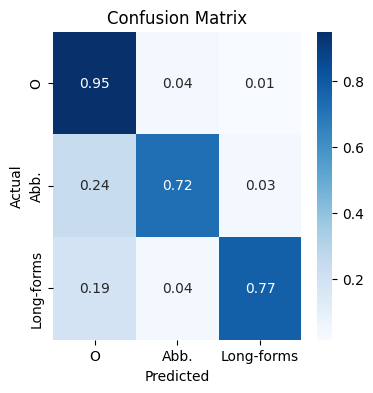

In [7]:
output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


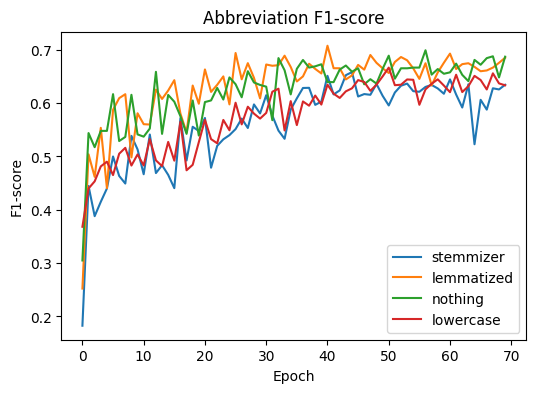

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,stemmizer,0.620,0.650,0.635,0.547,0.544,0.545,0.904
1,lemmatized,0.715,0.658,0.685,0.567,0.570,0.569,0.911
2,nothing,0.743,0.639,0.687,0.590,0.530,0.558,0.907
3,lowercase,0.595,0.677,0.633,0.617,0.530,0.570,0.908


In [8]:
tb_df = utils.from_tensorboard('tensorboard_runs/preprocessing', isString=True)
tb_df.head()

### 2.2 Model architecture

### 2.3 Vectorization methods

### 2.4 Loss functions and optimizers

## 3. Results and comparisons

## 4. Analysis of the results

In [9]:
# 5 random samples from the finetuned model

utils.show_visu(dataset, 'checkpoints/checkpoint-2000')

Output:  ( D ) Lysates of rectal cancer tissues before and after radiotherapy ( RT ) from each of the nine patients were subjected to SDS - PAGE and immunoblotting with antibodies against pY232 , pY291 , and C - terminal ( C - ter ) of Fas .
Truth:   ( D ) Lysates of rectal cancer tissues before and after radiotherapy ( RT ) from each of the nine patients were subjected to SDS - PAGE and immunoblotting with antibodies against pY232 , pY291 , and C - terminal ( C - ter ) of Fas . 

Output:  IMD , Index of Multiple Deprivation , derived from the Lower Super Output Area of the patient ’ s home address ; IQR , interquartile range .
Truth:   IMD , Index of Multiple Deprivation , derived from the Lower Super Output Area of the patient ’s home address ; IQR , interquartile range . 

Output:  2F , G ) , and we confirmed these results by quantitative Real Time Polymerase Chain Reaction ( qRT ) in sorted - PCRGFP - labeled cells ( S3B , C Fig .
Truth:   2F , G ) , and we confirmed these results 

## 5. Final evaluation